In [1]:
import numpy as np
from minisom import MiniSom 
from datetime import datetime
from itertools import chain
import matplotlib.pyplot as plt
from collections import defaultdict

In [2]:
# DATASETS
clusters10_data = np.genfromtxt('10clusters.vec', skip_header=4, usecols=list(range(10)))
chainlink_data = np.genfromtxt('chainlink.vec', skip_header=4, usecols=list(range(3)))

In [9]:
# Clusters10
clusters10_som_small = MiniSom(20, 25, 10, sigma=10, learning_rate=0.5, random_seed=10)
clusters10_som_small.train_random(clusters10_data, 10000)
clusters10_som_big = MiniSom(100, 60, 10, sigma=30, learning_rate=0.5, random_seed=10)
clusters10_som_big.train_random(clusters10_data, 10000)

In [3]:
# Chainlink
chainlink_som_small = MiniSom(20, 25, 3, sigma=10, learning_rate=0.1, random_seed=10, neighborhood_function='triangle')
chainlink_som_small.train_random(chainlink_data, 10000)
#chainlink_som_big = MiniSom(100, 60, 3, sigma=0.3, learning_rate=0.5)
#chainlink_som_big.train_random(chainlink_data, 10000)

In [6]:
class SOMLibExporter:    
    """
    Class for creating SOMLib files out of a SOM created by MiniSOM
    """
    
    def __init__(self, dataset, som, dataset_name):
        """
        Init the SOMLibExporter
        
        Arguments:
        dataset -- data the SOM is trained on
        som -- SOM we want to export
        dataset_name -- name of the data
        """
        self._data = dataset
        self._som = som
        self._dataset_name = dataset_name
        self._weights = som.get_weights()
        self._xdmin = self._weights.shape[0]
        self._ydmin = self._weights.shape[1]
        self._distances = som.distance_map()
        self._qe = som.quantization_error(dataset)
        self._quantization = som.quantization(dataset)
        
    def _get_header(self):
        """
        returns dict with header information of a SOMLib file
        """
        return {'$TYPE': 'som', '$GRID_LAYOUT': 'rectangular', '$GRID_TOPOLOGY': 'planar', 
                '$XDIM': self._xdmin, '$YDIM': self._ydmin, '$ZDMIN': 1}
        

    def write_map_file(self, filename, sigma=0.3, learning_rate=0.5, iterations=100, seed=1):   
        """
        Write SOMLib map description file
        
        Arguments:
        filename -- name of the output file
        sigma -- used sigma for training the SOM
        learning_rate -- used learning rate for training the SOM
        iterations -- used iterations for training the SOM
        seed -- used seed for training the SOM
        """
        d = self._get_header()
        d['$VEC_DIM'] = self._data.shape[1]
        d['$STORAGE_DATE'] = datetime.now().strftime("%d/%m/%Y %H:%M %p")
        d['$LEARNRATE_TYPE'] = 'exponential'
        d['$LEARNRATE_INIT'] = learning_rate
        d['$NEIGHBORHOOD_TYPE'] = 'exponential'
        d['$NEIGHBORHOOD_INIT'] = sigma
        d['$RAND_INIT'] = seed
        d['$ITERATIONS_TOTAL'] = iterations
        d['$QUANTERROR_MAP'] = self._qe
                
        with open(filename + ".map","w") as f:
            for key, value in d.items():
                f.write("{} {} \n".format(key, value))
    
    def write_weight_file(self, filename):
        """
        Write SOMLib weight vector file
        
        Arguments:
        filename -- name of the output file
        """
        d = self._get_header()
        d['$VEC_DIM'] = self._data.shape[1]
        
        with open(filename + ".wgt","w") as f:
            for key, value in d.items():
                f.write("{} {} \n".format(key, value))
                
            for i in range(self._weights.shape[0]):
                for j in range(self._weights.shape[1]):
                    l = list(self._weights[i][j])
                    l.append("SOM_MAP_{}_({}/{})".format(self._dataset_name, i, j))                
                    f.write(' '.join(map(str, l)) + "\n")
    
    def write_unit_file(self, filename):
        """
        Write SOMLib unit description file
        
        Arguments
        filename -- name of the output file
        """
        d = {"$TYPE": "rect", "$FILE_FORMAT_VERSION": 1.2, '$XDIM': self._xdmin, '$YDIM': self._ydmin, '$ZDMIN': 1}    
        winner_dict = self._map_data_to_winner()
        
        with open(filename + ".unit","w") as f:
            for key, value in d.items():
                f.write("{} {}\n".format(key, value))
            
            # map is traversed horizontally first
            for i in range(self._weights.shape[1]):
                for j in range(self._weights.shape[0]):
                    f.write("$POS_X {}\n".format(j))
                    f.write("$POS_Y {}\n".format(i))
                    f.write("$POS_Z 0\n")
                    f.write("$UNIT_ID {}_({}/{})\n".format(self._dataset_name, j, i))

                    if (j,i) in winner_dict:
                        qes = [self._qe_unit(idx - 1) for idx in winner_dict[(j,i)]] #idx - 1 since in SOMLib the idx are counted from 1
                        f.write("$QUANTERROR_UNIT {}\n".format(np.sum(qes)))
                        f.write("$QUANTERROR_UNIT_AVG {}\n".format(np.mean(qes)))
                        f.write("$NR_VEC_MAPPED {}\n".format(len(qes)))
                        f.write("$MAPPED_VECS\n")
                        for idx in winner_dict[(j,i)]:
                            f.write(str(idx) + "\n")
                        f.write("$MAPPED_VECS_DIST " + ' '.join(map(str, qes)) + "\n")

                    else:
                        f.write("$QUANTERROR_UNIT 0.0\n")
                        f.write("$QUANTERROR_UNIT_AVG 0.0\n")
                        f.write("$NR_VEC_MAPPED 0\n")

    def _qe_unit(self,idx):
        """
        returns qe for a single input vector
        
        Arguments:
        idx -- index of the input vector
        """
        return np.mean(np.power(self._quantization[idx] - self._data[idx],2))
           
    def _map_data_to_winner(self):
        """
        returns dict with idx of input vectors mapped to winner units
        """
        d = defaultdict(list)
        for i, vec in enumerate(self._data):
            d[self._som.winner(vec)].append(i + 1)
            
        return d
        

In [13]:
desc = SOMLibExporter(chainlink_data, chainlink_som_small, 'chainlink')
name = "small_chainlink"
desc.write_map_file(name, sigma=10, learning_rate=0.1, iterations=10000, seed=10)
desc.write_weight_file(name)
desc.write_unit_file(name)

In [24]:
clusters10_som_small.distance_map()[0]

array([0.07426911, 0.1458568 , 0.20181085, 0.27644098, 0.36663124,
       0.46186552, 0.5445832 , 0.59539283, 0.60147707, 0.56273153,
       0.49107238, 0.4040299 , 0.31794336, 0.24474132, 0.19202753,
       0.16317676, 0.15754348, 0.17167625, 0.20003784, 0.2376478 ,
       0.28068722, 0.32292051, 0.35639285, 0.37449225, 0.16400356])

In [19]:
desc = SOMLibExporter(clusters10_data, clusters10_som_small, '10clusters')
name = "small_10clusters"
desc.write_map_file(name, sigma=10, learning_rate=0.5, iterations=10000, seed=10)
desc.write_weight_file(name)
desc.write_unit_file(name)

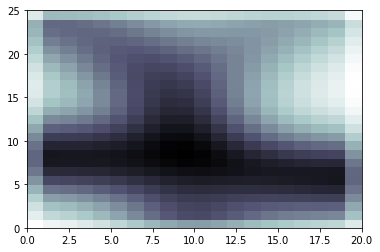

In [14]:
plt.pcolor(clusters10_som_small.distance_map().T, cmap='bone_r') 

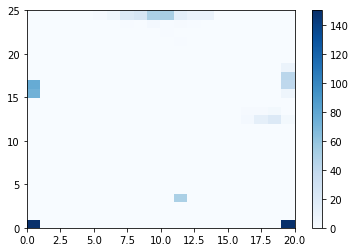

In [16]:
frequencies = clusters10_som_small.activation_response(clusters10_data)
plt.pcolor(frequencies.T, cmap='Blues') 
plt.colorbar()
plt.show()

In [20]:
import pickle
with open(name + ".p", 'wb') as outfile:
    pickle.dump(clusters10_som_small, outfile)